<a href="https://colab.research.google.com/github/Eddietrantkt/CF_Quan22280073_Tuong22280102/blob/main/FINANCE_week5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance pandas matplotlib mplfinance prophet scikit-learn

# Import Python Libraries and set defalut value

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
start_time = "2021-01-01"
end_time = datetime.now()
ngan_hang_vn = ["VCB.VN", "TCB.VN", "ACB.VN", "MBB.VN", "BID.VN", "CTG.VN", "HDB.VN", "TPB.VN", "MSB.VN", "SHB.VN"]

# Download price-volume data

In [4]:
data = yf.download(ngan_hang_vn, start=start_time, end=end_time, auto_adjust=False)
data.tail(3)

[*********************100%***********************]  10 of 10 completed


Price      Adj Close                                                        \
Ticker        ACB.VN   BID.VN   CTG.VN   HDB.VN   MBB.VN   MSB.VN   SHB.VN   
Date                                                                         
2025-11-11   24850.0  38000.0  48500.0  29600.0  23200.0  12100.0  15800.0   
2025-11-12   25200.0  38250.0  49200.0  30000.0  23700.0  12200.0  16300.0   
2025-11-13   25100.0  38300.0  48850.0  29950.0  23500.0  12100.0  16350.0   

Price                                  ...   Volume                      \
Ticker       TCB.VN   TPB.VN   VCB.VN  ...   ACB.VN   BID.VN     CTG.VN   
Date                                   ...                                
2025-11-11  33650.0  16900.0  58900.0  ...  7868106  2395129  8879696.0   
2025-11-12  35000.0  17300.0  59500.0  ...  7135256  2032983  6732674.0   
2025-11-13  35100.0  16950.0  59800.0  ...  5904781  1944401  5672727.0   

Price                                                                      \
Ticker        HDB.VN    MBB.VN   MSB.VN      SHB.VN      TCB.VN    TPB.VN   
Date                                                                        
2025-11-11  16090720  15240350  5453595  70353550.0  11457130.0   4340377   
2025-11-12  18588390  17656290  4379133  91832270.0  13033510.0  10843580   
2025-11-13  12084470  19659540  4513299  65475640.0  12761540.0   4904235   

Price                
Ticker       VCB.VN  
Date                 
2025-11-11  2586585  
2025-11-12  2222657  
2025-11-13  2658685  

[3 rows x 60 columns]

# Convert to DataFrame

In [5]:
data_stacked = data.stack(level='Ticker')
data_long = data_stacked.reset_index()
data_long = data_long.rename_axis(None, axis=1)
data_long = data_long.rename(columns={
    'Adj Close': 'Adjust Close',
    'Date': 'Date'
})
desired_columns = ['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Adjust Close', 'Volume']
final_columns = [col for col in desired_columns if col in data_long.columns]
data_final = data_long[final_columns]
# Đổi tên cột Ticker thành Ngan_hang_VN
data_final = data_final.rename(columns={'Ticker': 'Ngan_hang_VN'})
# Chuyển cột Date dùng làm Index
data_final = data_final.set_index('Date')

/tmp/ipython-input-1521832300.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  data_stacked = data.stack(level='Ticker')


In [6]:
df = data_final

# Bước 1: Tính log lợi nhuận

In [7]:
ticker = 'VCB.VN'
df_ticker = df[df['Ngan_hang_VN'] == ticker].copy()

# Tính log lợi nhuận
df_ticker['Log_Return'] = np.log(df_ticker['Close'] / df_ticker['Close'].shift(1))

# Bước 2: Áp dụng Time Series Modeling - Fit ARIMA để dự báo log returns

In [8]:
from statsmodels.tsa.arima.model import ARIMA

# Drop NaNs introduced by Log_Return calculation before fitting ARIMA
df_ticker.dropna(inplace=True)

# Set the frequency of the date index to 'D' (daily) to address the ValueWarning
df_ticker.index = pd.to_datetime(df_ticker.index)
df_ticker = df_ticker.asfreq('D') # Ensure daily frequency for ARIMA
df_ticker.ffill(inplace=True) # Fill any missing dates if introduced by asfreq

# Chọn order (p,d,q) đơn giản: (1,0,1) - Bạn có thể dùng auto_arima để tối ưu
model = ARIMA(df_ticker['Log_Return'], order=(1,0,1))
model_fit = model.fit()
forecast_steps = 1  # Dự báo 1 ngày tiếp theo
df_ticker['Forecast'] = model_fit.predict(start=0, end=len(df_ticker)-1)  # Dự báo in-sample cho đơn giản
# Để dự báo out-of-sample: forecast = model_fit.forecast(steps=forecast_steps)

# Bước 3: Áp dụng Volatility - Tính Bollinger Bands

In [9]:
window = 20  # Window cho mean và std
df_ticker['Rolling_Mean'] = df_ticker['Close'].rolling(window=window).mean()
df_ticker['Rolling_Std'] = df_ticker['Close'].rolling(window=window).std()
df_ticker['Upper_Band'] = df_ticker['Rolling_Mean'] + (df_ticker['Rolling_Std'] * 2)
df_ticker['Lower_Band'] = df_ticker['Rolling_Mean'] - (df_ticker['Rolling_Std'] * 2)
df_ticker.dropna(inplace=True)

# Bước 4: Xây dựng thuật toán giao dịch (kết hợp ARIMA forecast và Bollinger Bands)

In [11]:
# Ý tưởng: Mean Reversion với filter từ forecast
# - Buy (long) nếu giá < Lower_Band VÀ forecast > 0 (dự báo tăng)
# - Sell (short) nếu giá > Upper_Band VÀ forecast < 0 (dự báo giảm)
# - Hold nếu không

# Tạo tín hiệu (Signal)
buy_condition = (df_ticker['Close'] < df_ticker['Lower_Band']) & (df_ticker['Forecast'] > 0)
sell_condition = (df_ticker['Close'] > df_ticker['Upper_Band']) & (df_ticker['Forecast'] < 0)

df_ticker['Signal'] = np.where(buy_condition, 1, np.where(sell_condition, -1, 0))

# Tạo vị thế (Position) - Dịch chuyển 1 ngày để tránh "nhìn trước" (lookahead bias)
df_ticker['Position'] = df_ticker['Signal'].shift(1)

# Xóa NaNs tạo ra bởi .shift(1) ở đầu
df_ticker.dropna(inplace=True)

print(f"Đã tạo tín hiệu và vị thế. Dữ liệu cuối (tail):")
print(df_ticker[['Close', 'Lower_Band', 'Upper_Band', 'Forecast', 'Signal', 'Position']])

Đã tạo tín hiệu và vị thế. Dữ liệu cuối (tail):
                   Close    Lower_Band    Upper_Band  Forecast  Signal  \
Date                                                                     
2021-01-26  44786.734375  44129.045341  47601.643721 -0.001672       0   
2021-01-27  43233.179688  43722.643024  47581.928461 -0.005251       0   
2021-01-28  40214.847656  42275.767608  48398.505048 -0.011763       0   
2021-01-29  41280.140625  41574.563283  48575.939842 -0.024073       0   
2021-01-30  41280.140625  40997.595308  48629.138286  0.006172       0   
...                  ...           ...           ...       ...     ...   
2025-11-09  59300.000000  58738.756334  60751.243666 -0.005896       0   
2025-11-10  58800.000000  58644.727697  60795.272303 -0.005918       0   
2025-11-11  58900.000000  58549.403704  60820.596296 -0.003300       0   
2025-11-12  59500.000000  58532.875279  60807.124721  0.000146       0   
2025-11-13  59800.000000  58549.403704  60820.596296  0.003112  

# Bước 5: Backtest - Tính lợi nhuận

In [14]:
df_ticker['Strategy_Return'] = df_ticker['Position'] * df_ticker['Log_Return']
df_ticker['Cumulative_Market'] = np.cumsum(df_ticker['Log_Return'])  # Lợi nhuận thị trường (Buy and Hold)
df_ticker['Cumulative_Strategy'] = np.cumsum(df_ticker['Strategy_Return'])  # Lợi nhuận chiến lược

# Tính Sharpe Ratio (giả sử risk-free rate = 0)
# Thêm kiểm tra nếu std() = 0 (tránh lỗi chia cho 0)
if df_ticker['Strategy_Return'].std() != 0:
    sharpe_ratio = (df_ticker['Strategy_Return'].mean() / df_ticker['Strategy_Return'].std()) * np.sqrt(252)  # Annualized
    print(f"Sharpe Ratio của chiến lược: {sharpe_ratio}")
else:
    print("Lợi nhuận chiến lược không đổi, không thể tính Sharpe Ratio.")

print(df_ticker[['Log_Return', 'Position', 'Strategy_Return', 'Cumulative_Market', 'Cumulative_Strategy']].tail())

Sharpe Ratio của chiến lược: -0.8202379086004531
            Log_Return  Position  Strategy_Return  Cumulative_Market  \
Date                                                                   
2025-11-09   -0.016723       0.0             -0.0          -0.335414   
2025-11-10   -0.008467       0.0             -0.0          -0.343882   
2025-11-11    0.001699       0.0              0.0          -0.342183   
2025-11-12    0.010135       0.0              0.0          -0.332047   
2025-11-13    0.005029       0.0              0.0          -0.327018   

            Cumulative_Strategy  
Date                             
2025-11-09            -0.250643  
2025-11-10            -0.250643  
2025-11-11            -0.250643  
2025-11-12            -0.250643  
2025-11-13            -0.250643  


# Vẽ biểu đồ

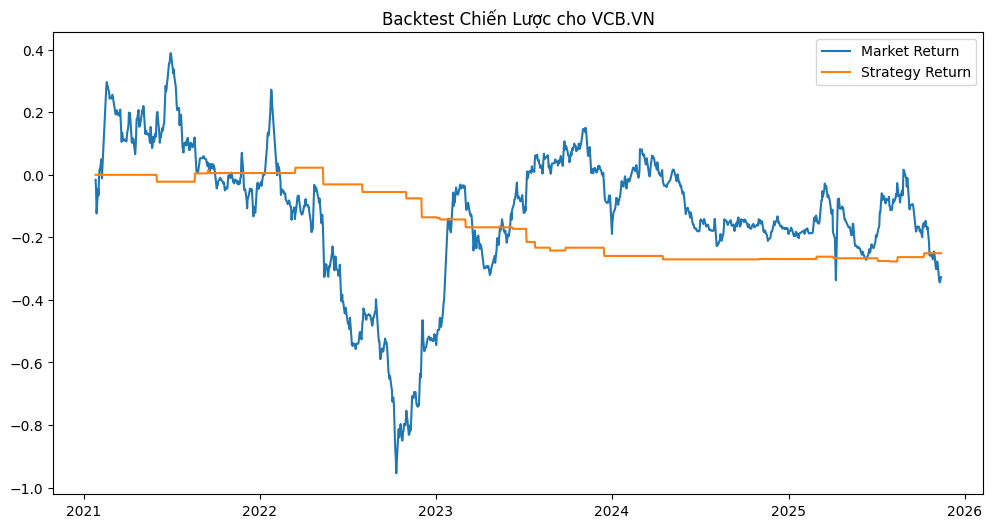

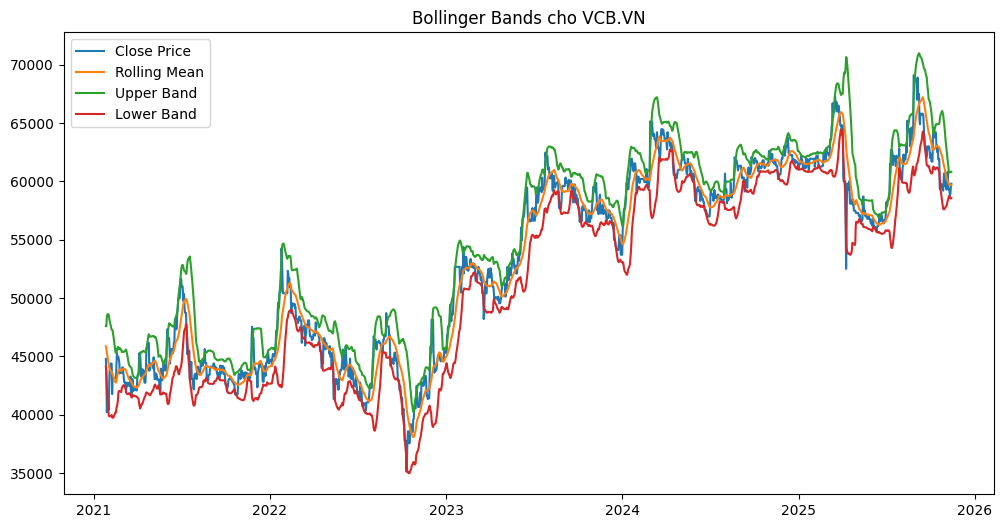

In [13]:
# Vẽ biểu đồ backtest
plt.figure(figsize=(12, 6))
plt.plot(df_ticker['Cumulative_Market'], label='Market Return')
plt.plot(df_ticker['Cumulative_Strategy'], label='Strategy Return')
plt.title(f'Backtest Chiến Lược cho {ticker}')
plt.legend()
plt.show()

# Vẽ Bollinger Bands
plt.figure(figsize=(12, 6))
plt.plot(df_ticker['Close'], label='Close Price')
plt.plot(df_ticker['Rolling_Mean'], label='Rolling Mean')
plt.plot(df_ticker['Upper_Band'], label='Upper Band')
plt.plot(df_ticker['Lower_Band'], label='Lower Band')
plt.title(f'Bollinger Bands cho {ticker}')
plt.legend()
plt.show()